In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
import seaborn as sns

In [6]:
import numpy as np

In [7]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm

In [8]:
from scipy.stats import kde

In [9]:
from tqdm import tqdm_notebook

In [10]:
from scipy.optimize import minimize

## синтезирую задачу

In [11]:
x_class1 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([5, 5])

In [12]:
x_class0 = np.random.randn(1000, 2)*np.array([3, 2])-np.array([2, 2])

In [13]:
y = np.squeeze(np.concatenate([np.ones((1000,1), dtype=int), np.zeros((1000,1), dtype=int)], axis=0))

In [14]:
x = np.concatenate([x_class1, x_class0], axis=0)
x.shape

(2000, 2)

In [15]:
nbins=300

In [16]:
xmesh, ymesh = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]

In [17]:
k_class0 = kde.gaussian_kde(x_class0.T)
dens_class0 = k_class0(np.vstack([xmesh.flatten(), ymesh.flatten()]))

In [18]:
k_class1 = kde.gaussian_kde(x_class1.T)
dens_class1 = k_class1(np.vstack([xmesh.flatten(), ymesh.flatten()]))

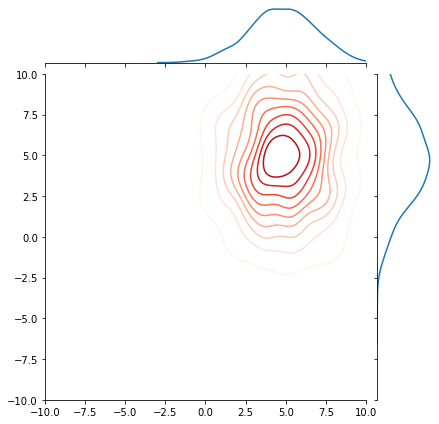

In [19]:
p = sns.jointplot(x=x_class1[:,0], y=x_class1[:,1], kind='kde', cmap='Reds')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)

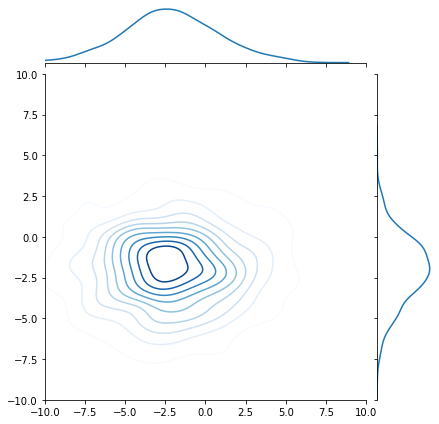

In [20]:
p = sns.jointplot(x=x_class0[:,0], y=x_class0[:,1], kind='kde', cmap='Blues')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)

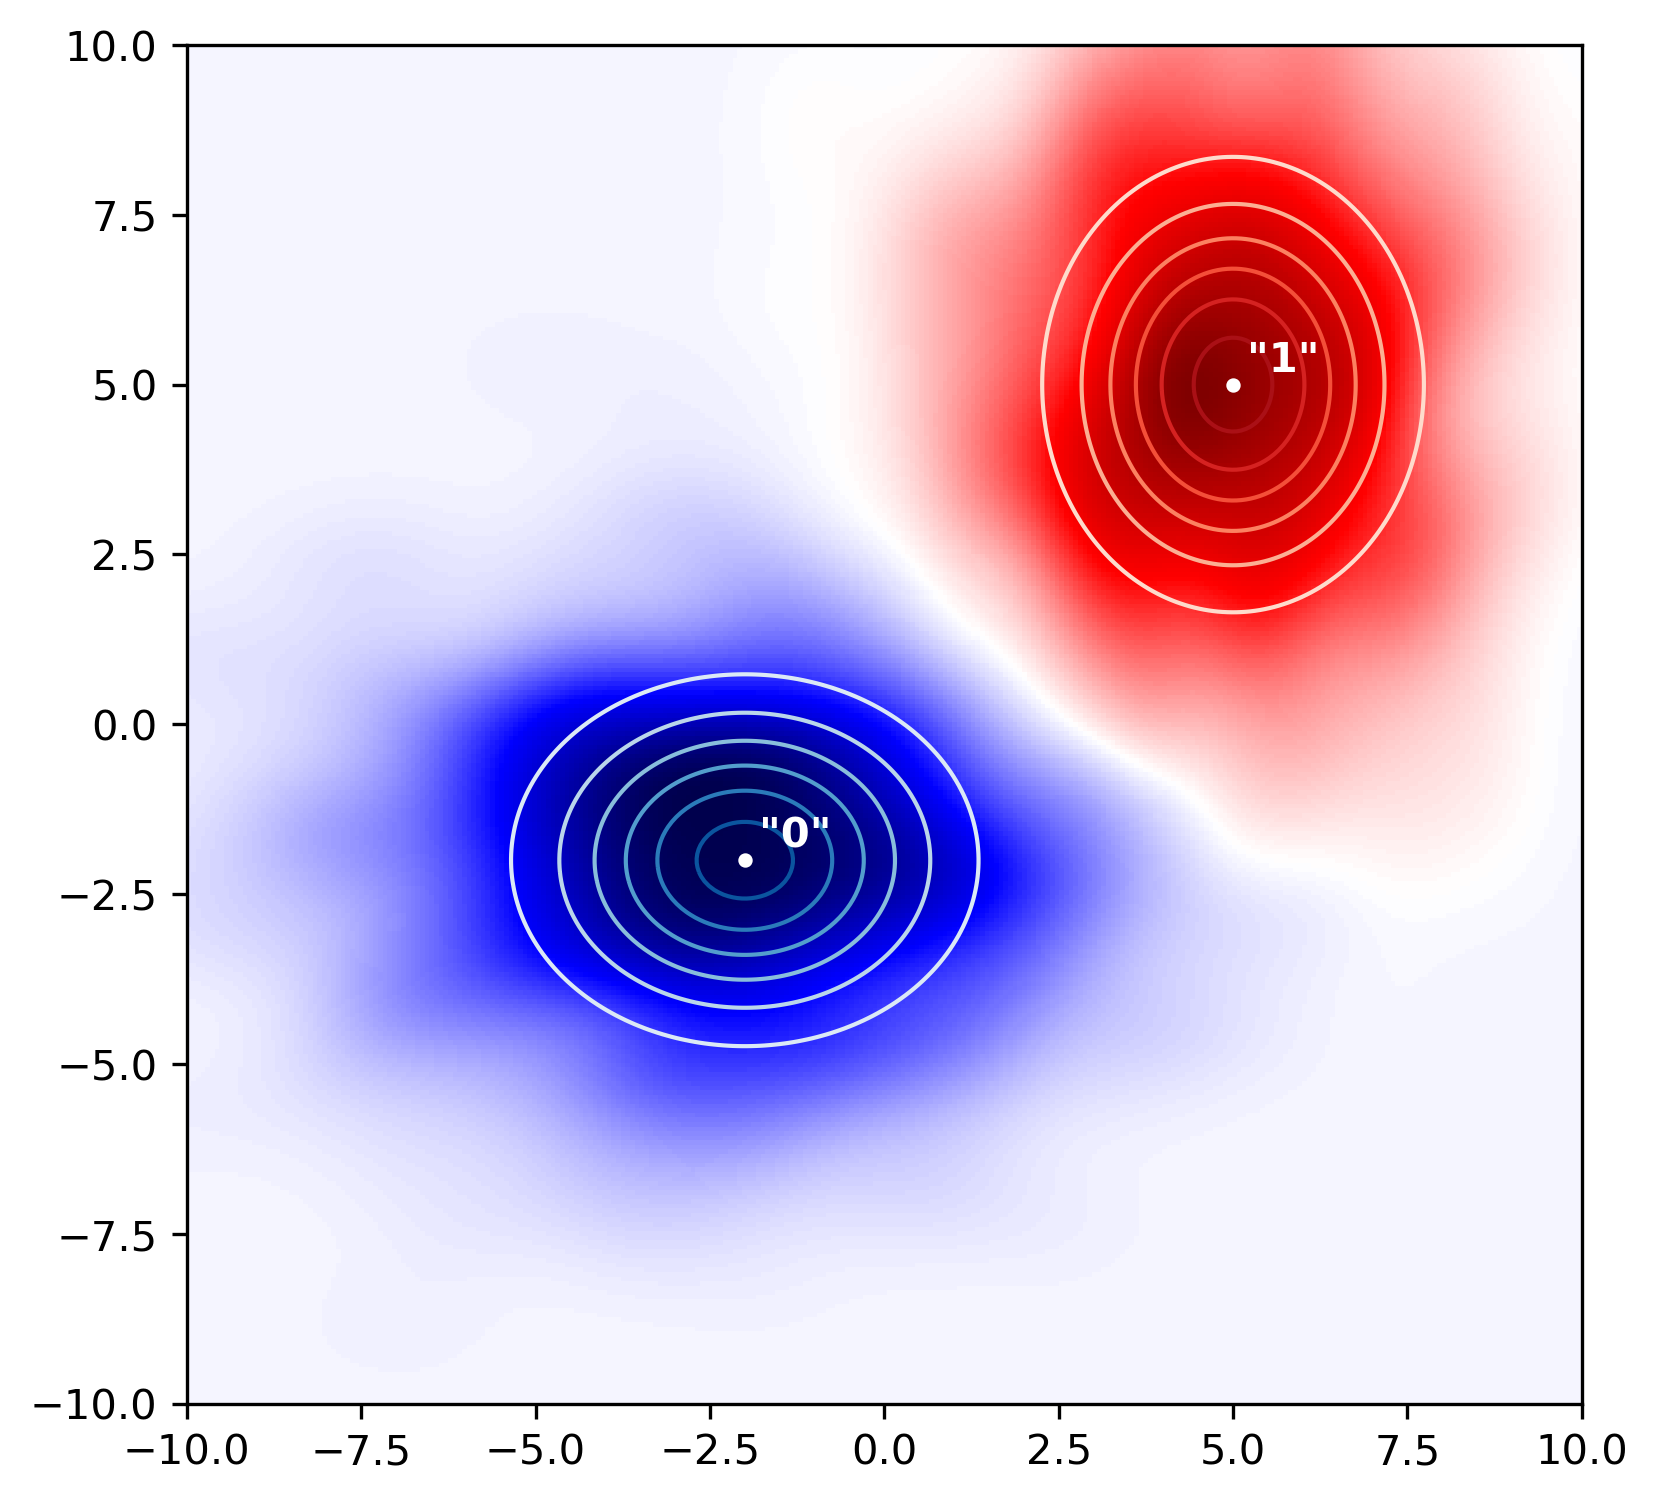

In [21]:
_ = plt.figure(figsize=(6,6), dpi=300)

rv = mnorm([5, 5], [[2.0, 0.0], [0.0, 3.0]])
norm_class1 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))
rv = mnorm([-2, -2], [[3.0, 0.0], [0.0, 2.0]])
norm_class0 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))
_ = plt.pcolormesh(xmesh, ymesh, (dens_class1-dens_class0).reshape(xmesh.shape), cmap='seismic')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'"1"', color='white', fontweight='bold')

_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, '"0"', color='white', fontweight='bold')
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)

In [22]:
x.shape

(2000, 2)

In [23]:
X_0 = np.ones((x.shape[0], 1), dtype=np.float)

In [24]:
X_matrix = np.concatenate([X_0, x], axis=1)

In [25]:
X_matrix.shape

(2000, 3)

In [26]:
theta_start = np.random.randn(x.shape[1]+1)

In [27]:
theta_start

array([-0.51342092, -0.05077012, -0.72169699])

In [28]:
theta_start[:,np.newaxis]

array([[-0.51342092],
       [-0.05077012],
       [-0.72169699]])

$\sigma(\theta X) = \frac{1}{1+e^{-\theta\cdot X}}$

In [29]:
p = 1/(1+np.exp(-np.dot(X_matrix, theta_start[:,np.newaxis])))

In [30]:
p.shape

(2000, 1)

In [31]:
p

array([[0.00144726],
       [0.00264282],
       [0.00089266],
       ...,
       [0.23531253],
       [0.84748921],
       [0.71440356]])

In [32]:
pred = (p>=0.5).astype(np.int32)

In [33]:
pred = 1-pred

In [34]:
pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [35]:
pred.shape

(2000, 1)

In [36]:
y_true = y[:,np.newaxis]

In [37]:
y_true.shape

(2000, 1)

Пусть в этой задаче мерой качества будет доля верных ответов (Accuracy)

In [38]:
(pred == y_true)

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [39]:
acc = (pred == y_true).mean()

In [40]:
acc

0.875

Ради интереса посмотрим, какое качество дает константная модель, которая для всех объектов выдает ответ "1"

In [41]:
const_pred = np.ones_like(y_true, dtype=np.int32)

In [42]:
acc_const_model = (const_pred == y_true).mean()

In [43]:
acc_const_model

0.5

In [50]:
rand_pred = np.random.randint(0, 2, y_true.shape, dtype=bool)

In [51]:
np.unique(rand_pred)

array([False,  True])

In [52]:
acc_rand_model = (rand_pred == y_true).mean()

In [53]:
acc_rand_model

0.5075

Посчитаем функцию потерь для каждого отдельного элемента, осредним (или просуммируем) их (см формулу перекрестной энтропии в слайдах лекции)

In [54]:
loss_elementwise = -y_true*np.log(p) - (1-y_true)*np.log(1-p)

In [55]:
loss_elementwise.shape

(2000, 1)

In [56]:
loss_elementwise

array([[6.53808413],
       [5.93590773],
       [7.02130847],
       ...,
       [0.26828806],
       [1.88051992],
       [1.25317552]])

In [57]:
loss_elementwise.mean()

2.985159597327386

Посчитаем градиент ф-ии потерь по параметрам модели (см формулу в слайдах лекции)

In [58]:
grad = -(y_true-p)*X_matrix

In [59]:
grad.shape

(2000, 3)

In [61]:
grad.mean(axis=0, keepdims=True).T

array([[-0.1317432 ],
       [-3.04838817],
       [-3.38823008]])

## Логистическая регрессия своими руками

#### implementing loss function and its gradient w.r.t. parameters $\theta$

In [63]:
def loss(X,y,curr_theta):
    X_0 = np.ones((X.shape[0], 1), dtype=np.float)
    X_matrix = np.concatenate([X_0, X], axis=1)
    p = 1/(1+np.exp(-np.dot(X_matrix, curr_theta[:,np.newaxis])))
    y_true = y[:,np.newaxis]
    l = -y_true*np.log(p) - (1-y_true)*np.log(1-p)
    return float(np.squeeze(l.mean(axis=0, keepdims=True)))
    

def loss_grad(X,y,curr_theta):
    assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
    
    X_0 = np.ones((X.shape[0], 1), dtype=np.float)
    X_matrix = np.concatenate([X_0, X], axis=1)
    
    p = 1/(1+np.exp(-np.dot(X_matrix, curr_theta[:,np.newaxis])))
    y_true = y[:,np.newaxis]
    
    grad = -(y_true-p)*X_matrix
    
    return grad.mean(axis=0, keepdims=True).T

In [64]:
# start point
theta_start = np.random.randn(x.shape[1] + 1)
theta_start

array([-0.87593437,  1.15589679,  0.9326879 ])

In [65]:
loss_history = []
steps = []

In [67]:
def optimization_callback(current_theta):
    loss_history.append(loss(x,y,current_theta))
    steps.append(len(steps))

In [68]:
optimization_result = minimize(lambda theta: loss(x, y, theta),
                               theta_start,
                               jac = lambda theta: np.squeeze(loss_grad(x, y, theta)),
                               callback = lambda t: optimization_callback(t))

In [69]:
optimization_result.x

array([-3.09485683,  1.0478283 ,  1.19862648])

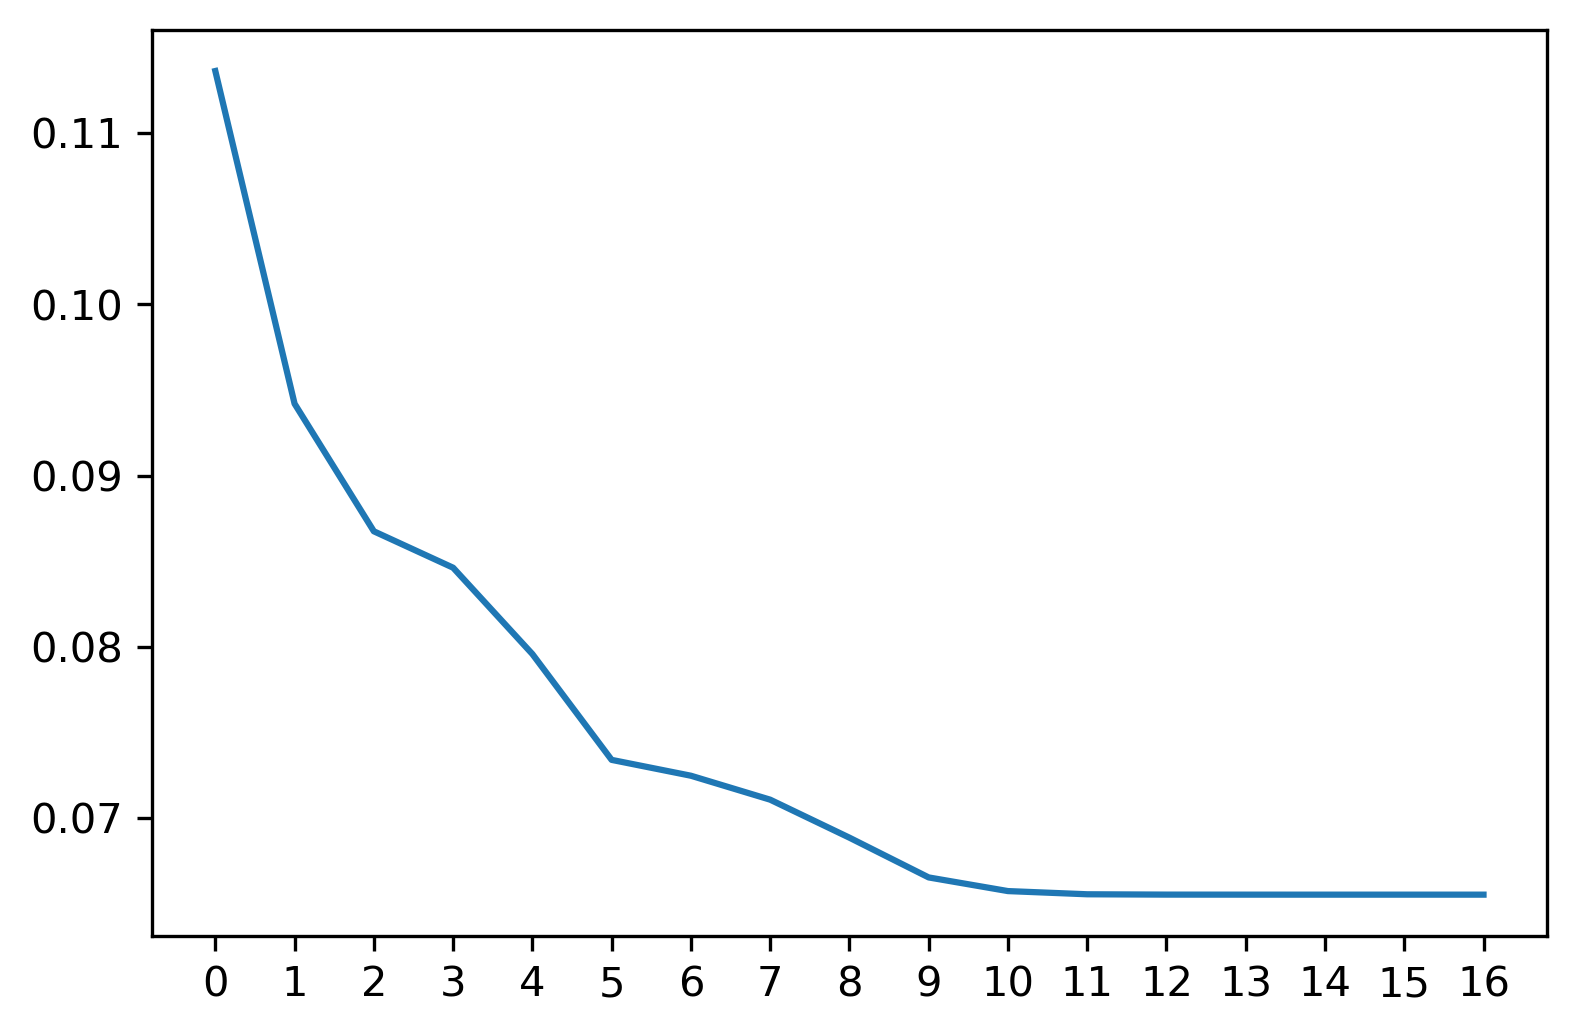

In [70]:
f = plt.figure(figsize=(6,4), dpi=300)
plt.plot(steps, loss_history)
plt.xticks(steps);

Оценим точность модели в мере доли верных ответов (accuracy)

In [71]:
theta_optim = optimization_result.x

In [72]:
p = 1/(1+np.exp(-np.dot(X_matrix, theta_optim[:,np.newaxis])))

In [73]:
pred = (p>=0.5).astype(np.int32)

In [74]:
acc = (pred == y_true).mean()

In [75]:
acc

0.9755

### Теперь сделаем по-правильному: с оценкой неопределенности меры качества методом Bootstrap

In [76]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

### Logistic regression implementation (without any regularizations, with default optimization parameters)

In [77]:
class LogRegression:
    def __init__(self):
        self.theta = None
    
    def compute_probabilities(self, X_matrix, theta):
        p = 1/(1+np.exp(-np.dot(X_matrix, theta[:,np.newaxis])))
        return p
    
    def loss(self, X_matrix, y, curr_theta):
        p = self.compute_probabilities(X_matrix, curr_theta)
        y_true = y[:,np.newaxis]
        l = -y_true*np.log(p) - (1-y_true)*np.log(1-p)
        return float(np.squeeze(l.mean(axis=0, keepdims=True)))
    
    def loss_grad(self, X_matrix, y, curr_theta):
        p = self.compute_probabilities(X_matrix, curr_theta)
        y_true = y[:,np.newaxis]
        grad = -(y_true-p)*X_matrix
        return grad.mean(axis=0, keepdims=True).T
    
    
    def fit(self, X, y, epsilon=1e-4, etha=1e-3):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (y.ndim == 1), "y should be 1-dimensional"
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        theta_start = np.random.randn(X_matrix.shape[1], 1)
        loss_history = []
        optimization_result = minimize(lambda t: self.loss(X_matrix, y, t),
                                       theta_start,
                                       jac = lambda t: np.squeeze(self.loss_grad(X_matrix, y, t)),
                                       callback = lambda xk: loss_history.append(self.loss(X_matrix, y, xk)))
        
        self.theta = optimization_result.x
        return loss_history
    
    def predict(self, X, return_proba = False):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (self.theta is not None), "parameters are None. perhaps, you should fit the model first."
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        p = self.compute_probabilities(X_matrix, self.theta)
        y_pred = (p>=0.5).astype(int)
        
        if return_proba:
            return y_pred, p
        else:
            return y_pred

Проверим, что класс лог-регрессии работает верно

In [78]:
sample_size = x.shape[0]
Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
LR = LogRegression()
LR.fit(Xtrain, ytrain)
yoob_pred,yoob_proba = LR.predict(Xoob, return_proba=True)
print('accuracy: ' + str(np.mean(np.squeeze(yoob_pred)==yoob)))

accuracy: 0.9781420765027322


In [79]:
B = 2000
sample_size = x.shape[0]
acc = []
for i in tqdm_notebook(range(B), total=B):
    Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
    LR = LogRegression()
    LR.fit(Xtrain, ytrain)
    yoob_pred,yoob_proba = LR.predict(Xoob, return_proba=True)
    acc.append(np.mean(np.squeeze(yoob_pred)==yoob))

  0%|          | 0/2000 [00:00<?, ?it/s]

In [81]:
np.array(acc).mean(), np.array(acc).std()*1.96

(0.9725071990453589, 0.018583229059285063)

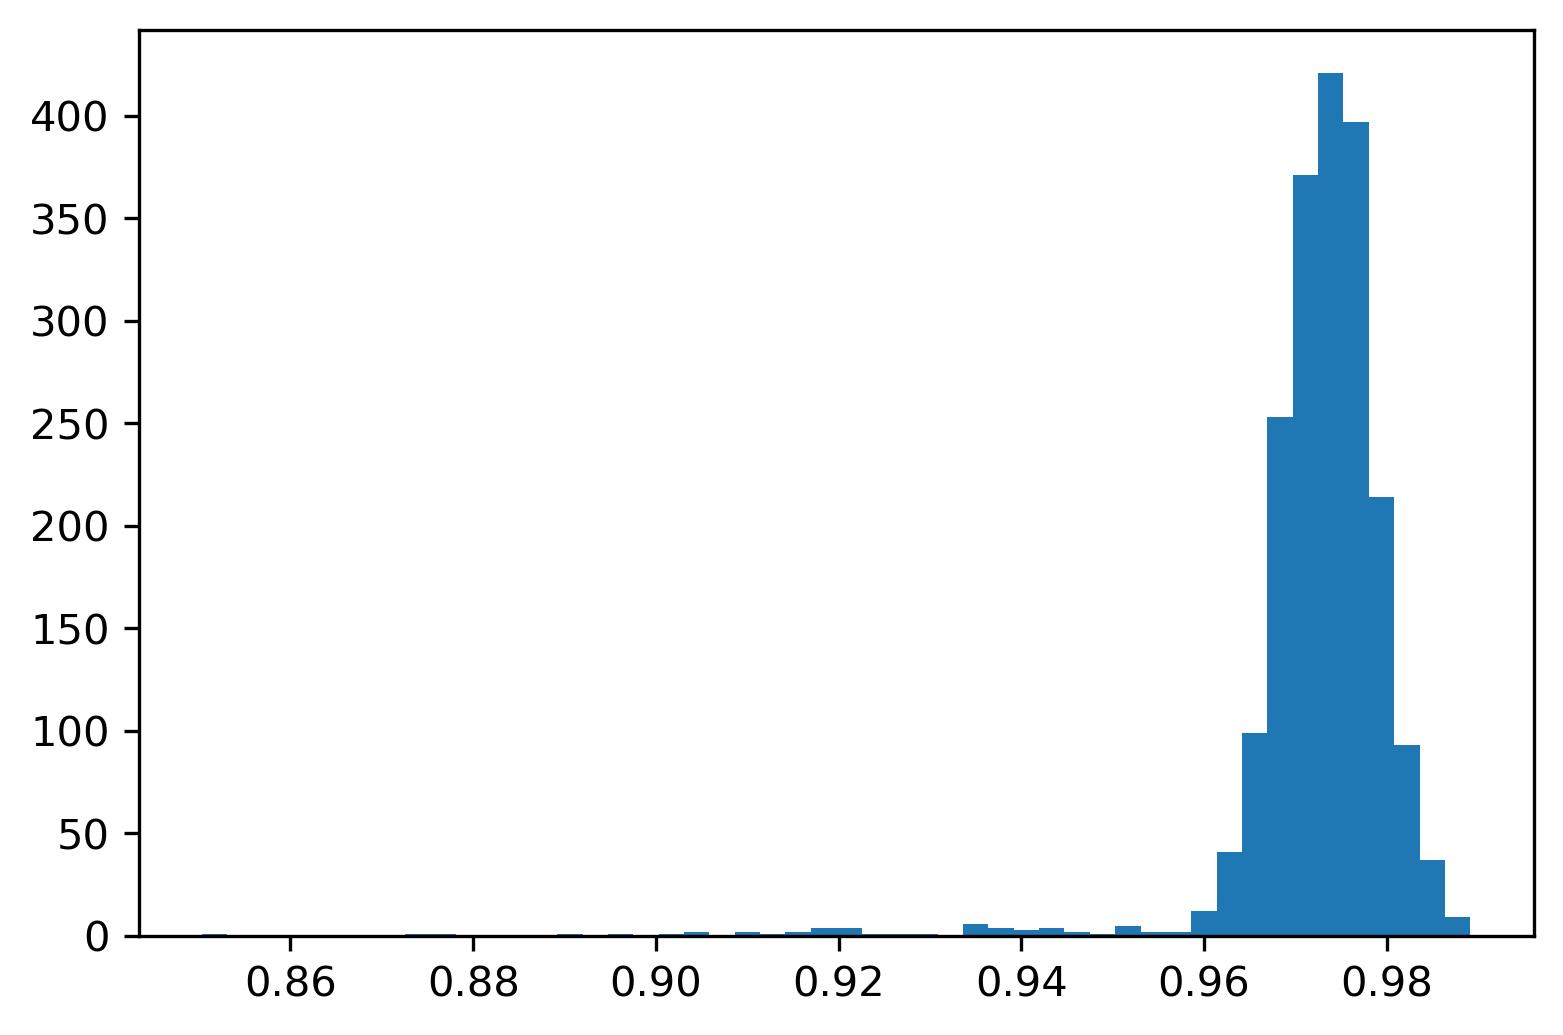

In [82]:
_ = plt.figure(figsize=(6,4), dpi=300)
_ = plt.hist(acc, bins=50)

In [83]:
LR = LogRegression()
LR.fit(Xtrain, ytrain)
yoob_pred,yoob_proba = LR.predict(Xoob, return_proba=True)

## то же самое, но с использованием sklearn

##### Просто чтобы удостовериться, что наш код работает так же, как у остальных $N$ тысяч специалистов, которые не утруждаются реализовать модель логистической регрессии самостоятельно

In [84]:
from sklearn.linear_model import LogisticRegression

In [85]:
lrmodel = LogisticRegression()

In [86]:
_ = lrmodel.fit(Xtrain, ytrain)

In [87]:
yoob_pred_sk = lrmodel.predict(Xoob)
yoob_proba_sk = lrmodel.predict_proba(Xoob)

##### сверим результаты

In [88]:
np.mean(np.squeeze(yoob_pred) == yoob_pred_sk)

1.0

## voilà ↑

### Отобразим оценки вероятностей в пространстве признаков

In [89]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [90]:
preds_mesh,probas_mesh = LR.predict(x_test_mesh, return_proba=True)

In [91]:
probas_mesh_class1 = probas_mesh.reshape(xmesh.shape)
probas_mesh_class0 = (1-probas_mesh).reshape(xmesh.shape)

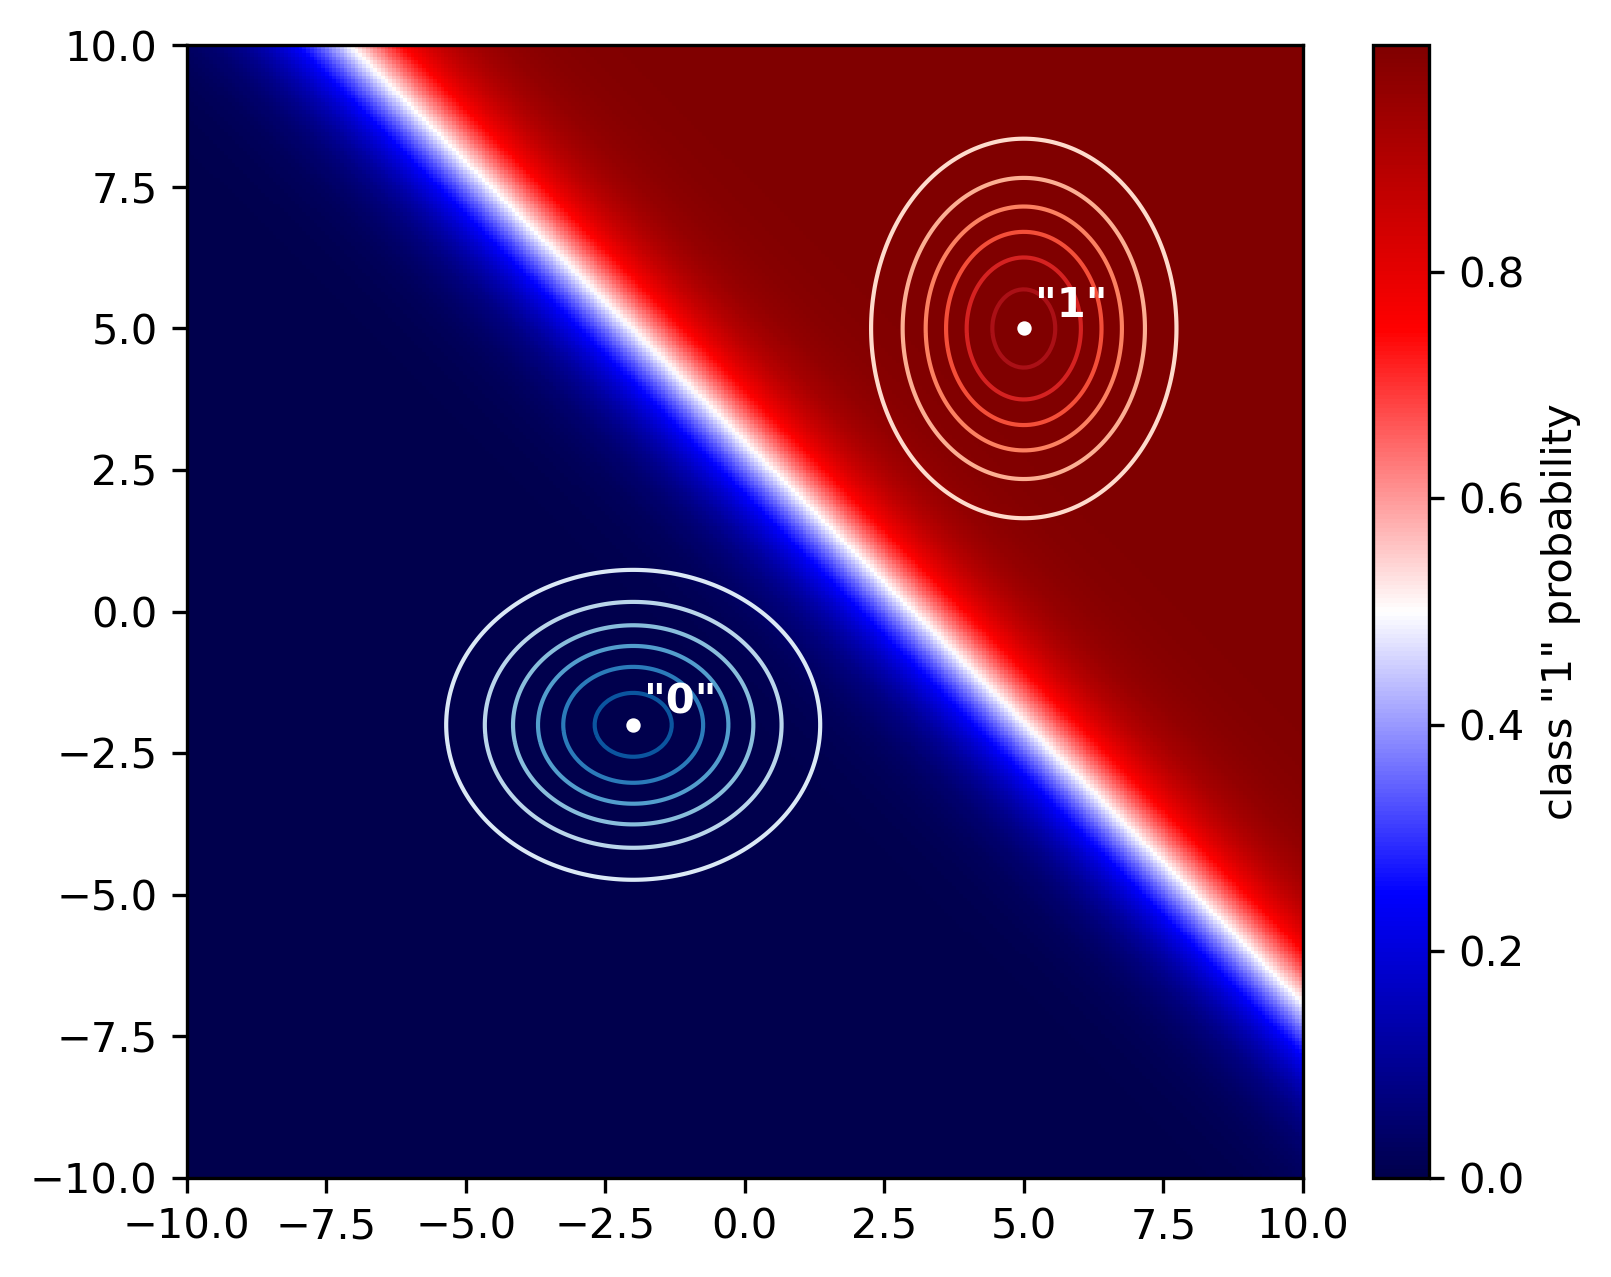

In [92]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, probas_mesh_class1, cmap='seismic')
cb = plt.colorbar()
cb.set_label('class "1" probability')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'"1"', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, '"0"', color='white', fontweight='bold')

### Отобразим вероятность для событий вдоль сечения "0"-"1"

In [93]:
p0 = np.array([-2, -2])
p1 = np.array([5, 5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [94]:
preds_linspace,probas_linspace = LR.predict(linspace, return_proba=True)

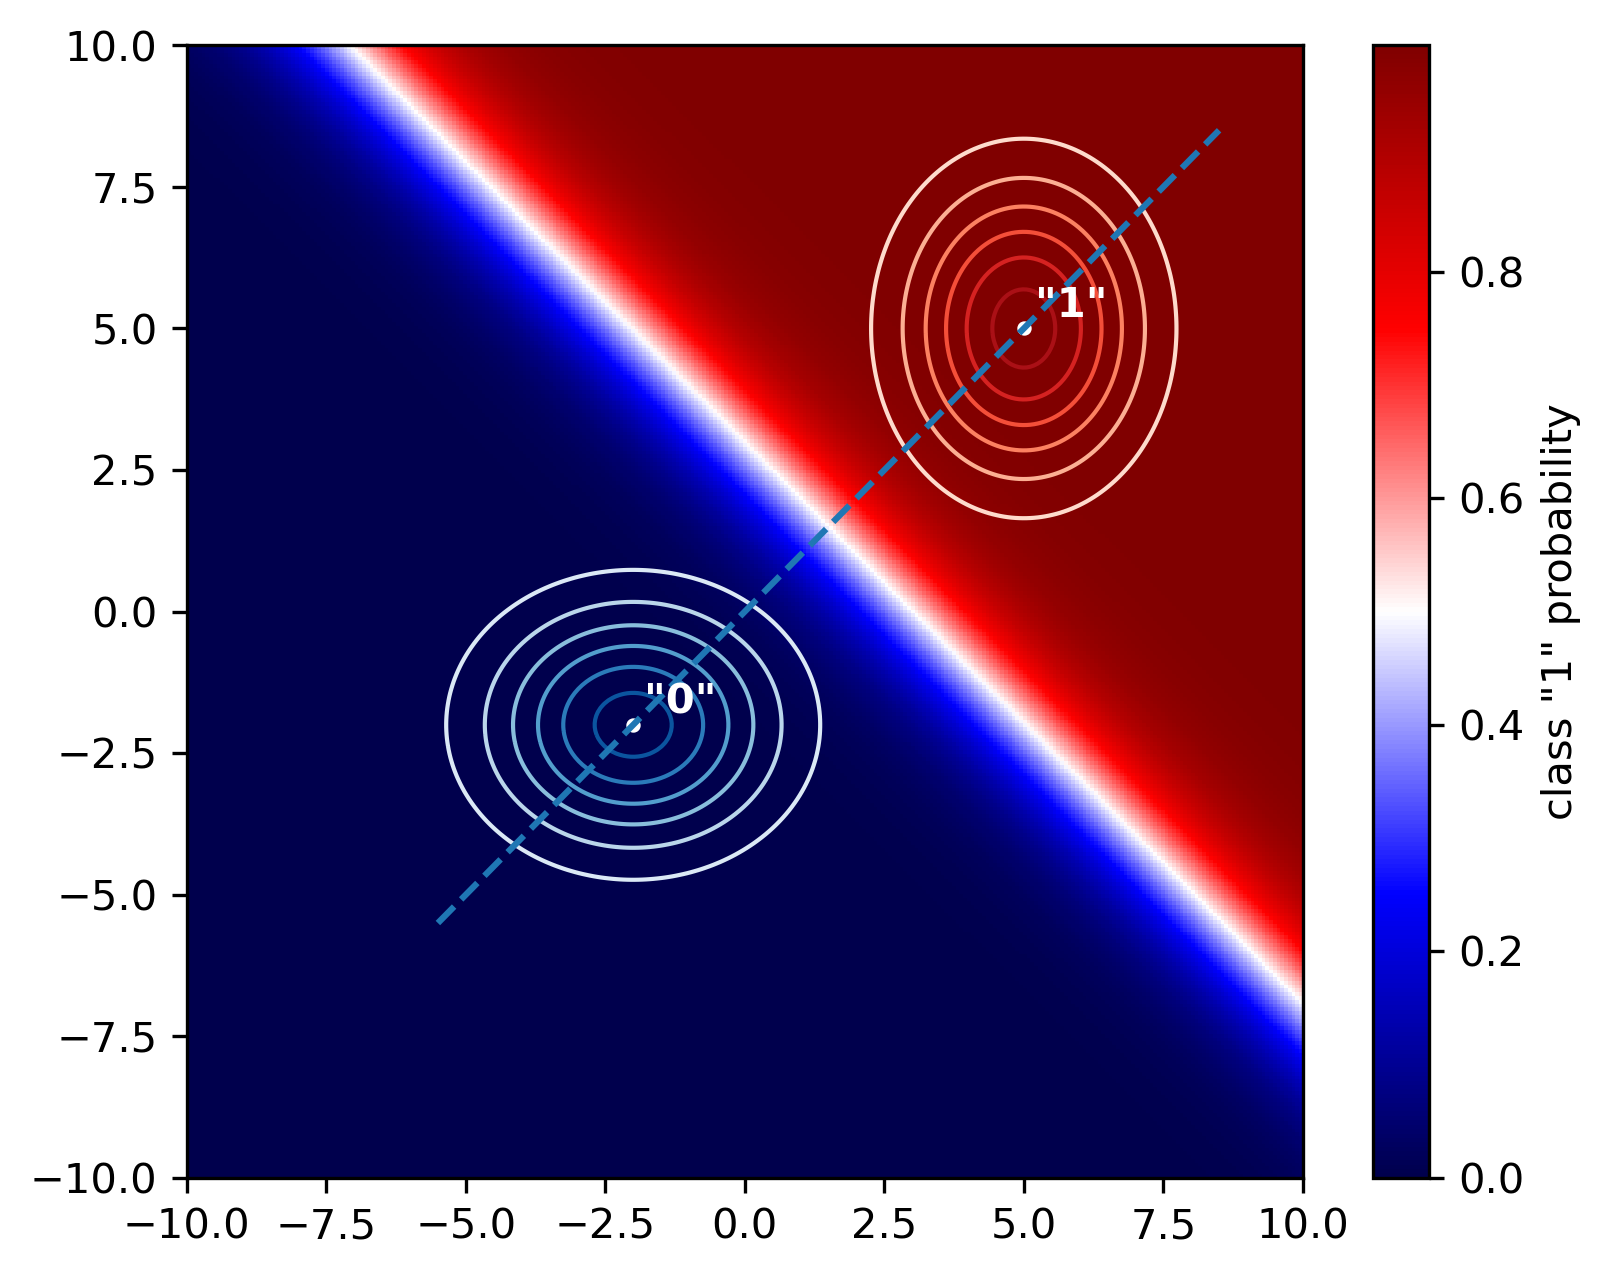

In [95]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, probas_mesh_class1, cmap='seismic')
cb = plt.colorbar()
cb.set_label('class "1" probability')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'"1"', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, '"0"', color='white', fontweight='bold')
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

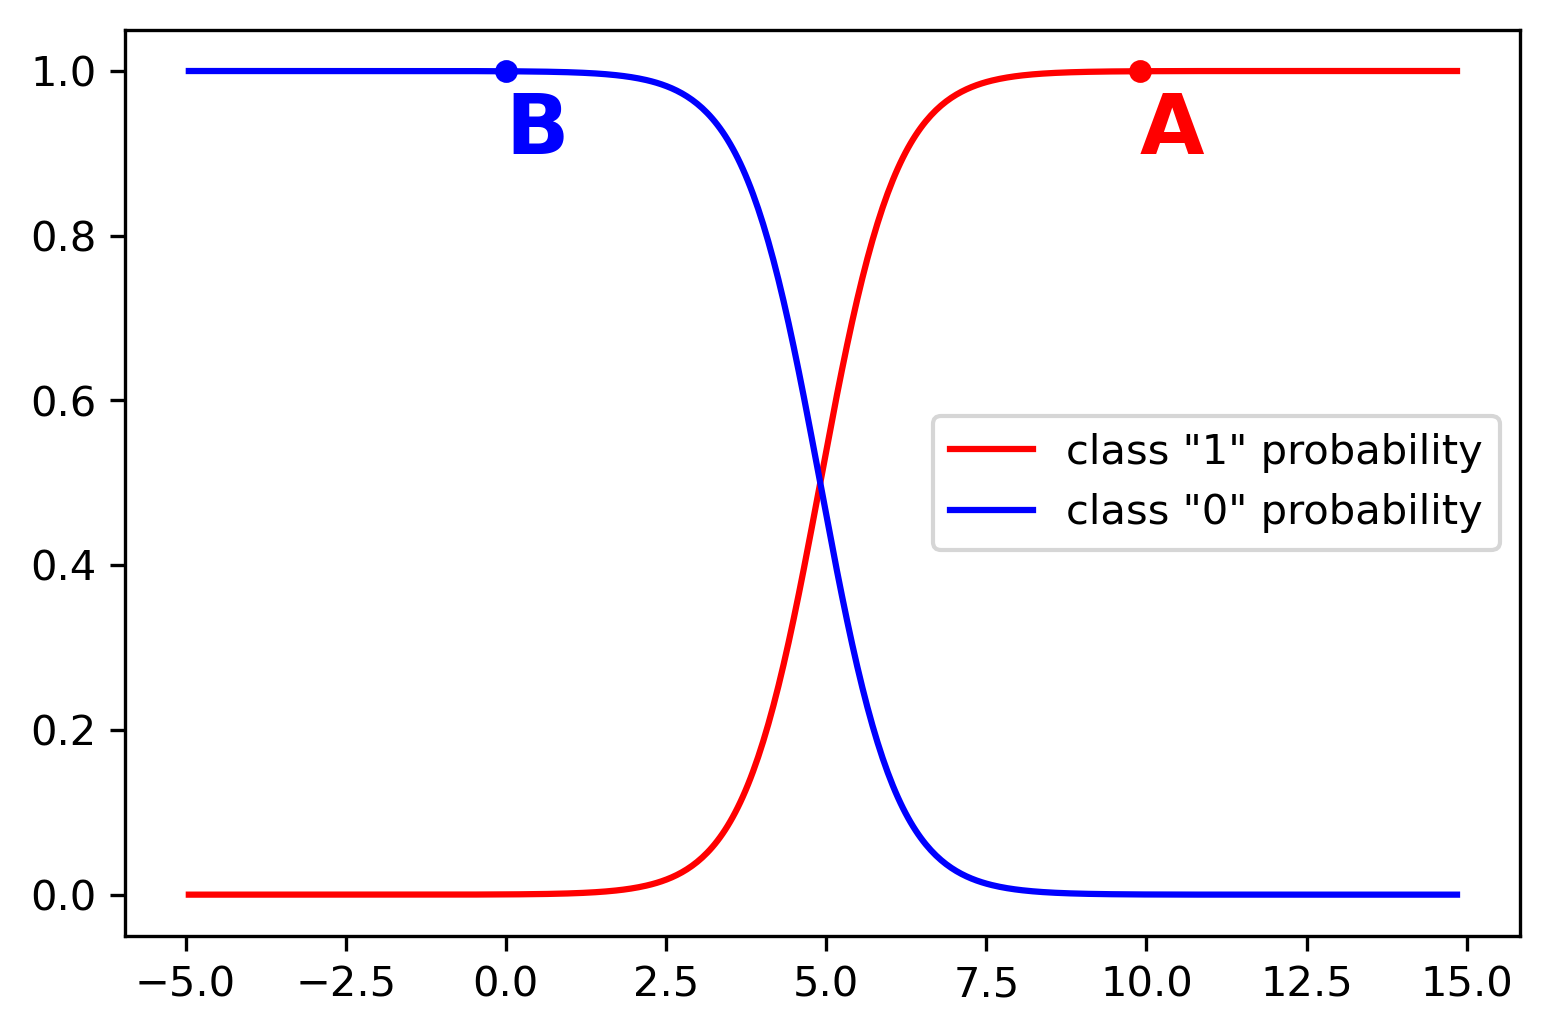

In [96]:
_ = plt.figure(figsize=(6,4), dpi=300)
_ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
             probas_linspace[:,0],
             color='red',
             label='class "1" probability')
_ = plt.scatter([np.linalg.norm(p1-p0)], [1.0], s=20, color='red')
_ = plt.text(np.linalg.norm(p1-p0), 0.9, 'A', color='red', fontweight='bold', fontsize=20)
_ = plt.scatter([0.0], [1.0], s=20, color='blue')
_ = plt.text(0, 0.9, 'B', color='blue', fontweight='bold', fontsize=20)
_ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
             1-probas_linspace[:,0],
             color='blue',
             label='class "0" probability')
plt.legend()

## Разделяющая поверхность

In [97]:
p_th = 0.5

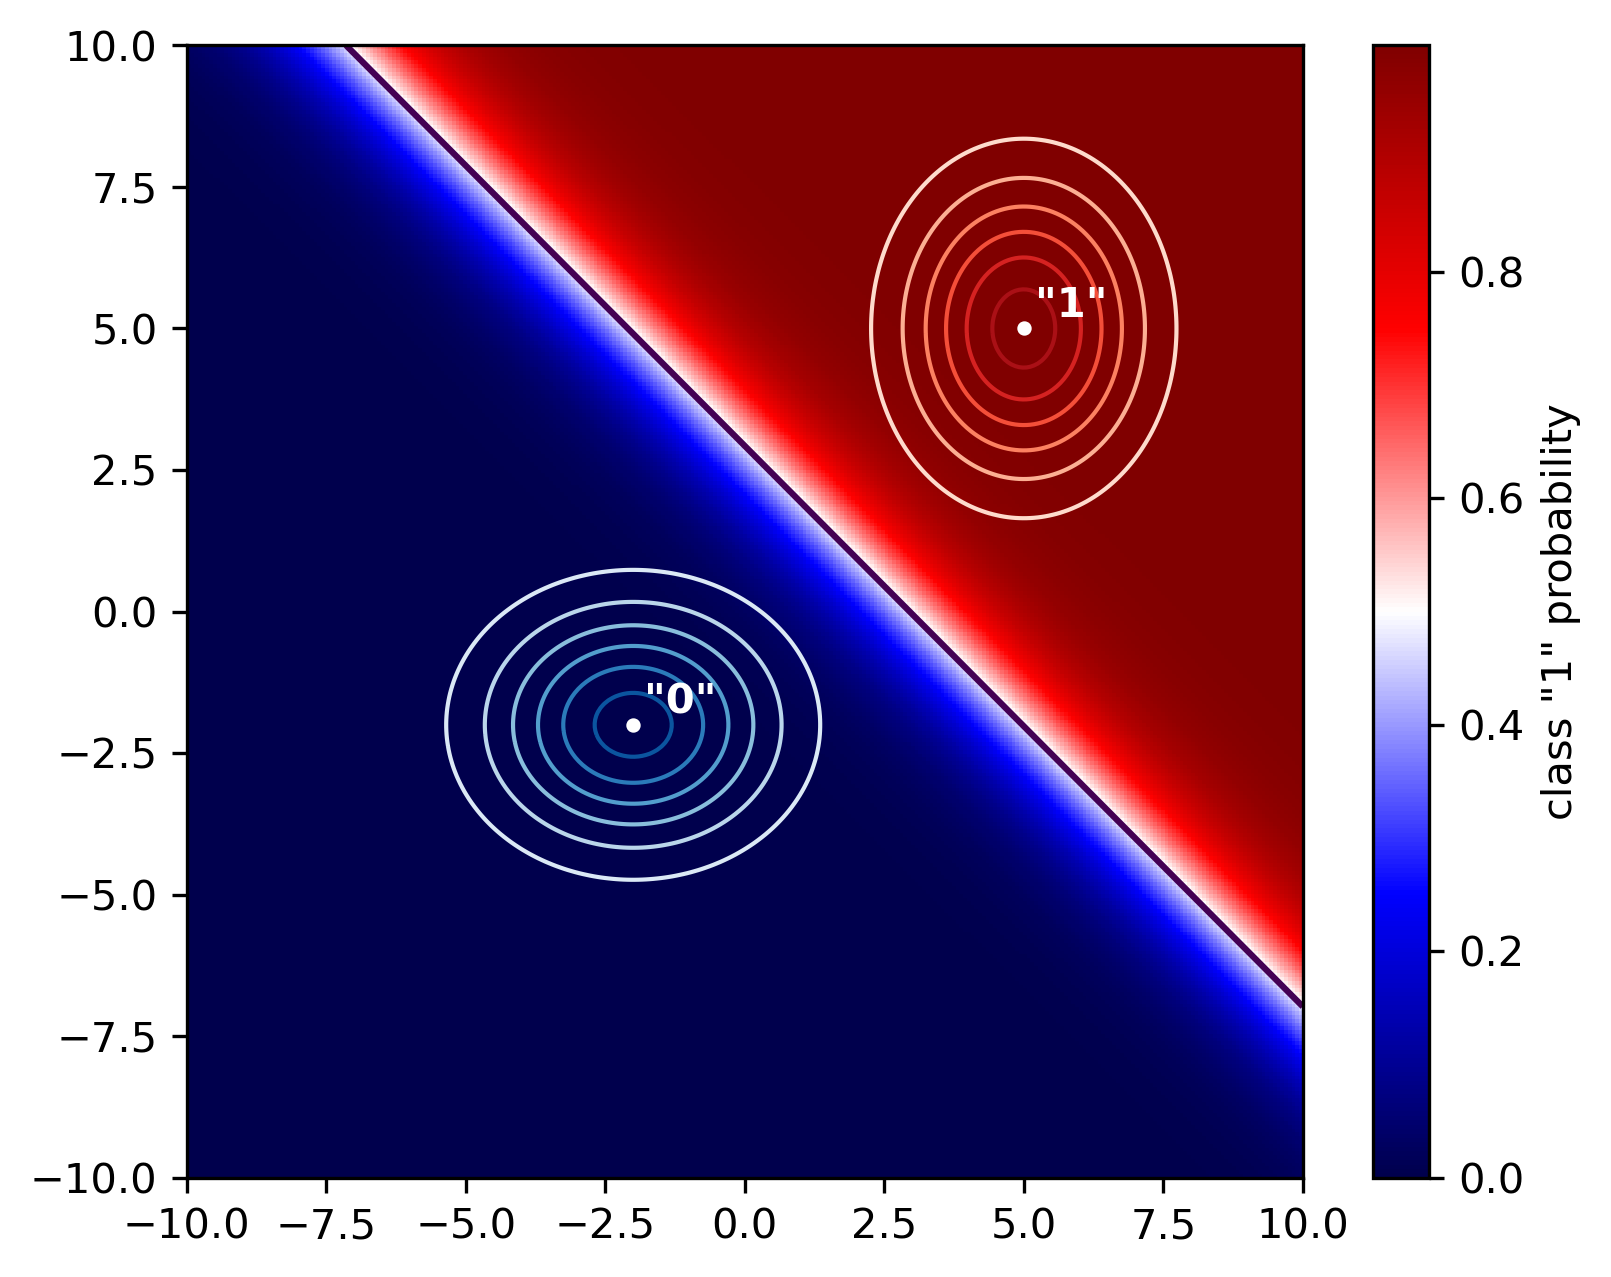

In [98]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)
_ = plt.pcolormesh(xmesh, ymesh, probas_mesh_class1, cmap='seismic')
cb = plt.colorbar()
cb.set_label('class "1" probability')
_ = plt.contour(xmesh, ymesh, norm_class1, cmap='Reds', linewidths=1)
_ = plt.scatter([5], [5], s=6, c='white')
_ = plt.text(5.2,5.2,'"1"', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, norm_class0, cmap='Blues', linewidths=1)
_ = plt.scatter([-2], [-2], s=6, c='white')
_ = plt.text(-1.8, -1.8, '"0"', color='white', fontweight='bold')
_ = plt.contour(xmesh, ymesh, probas_mesh_class1, levels=[0.5])